In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torchvision import datasets,transforms
import os
from PIL import Image
from IPython.display import display
device = torch.device("mps")

In [2]:
root = '/Users/aadityajoshi/Downloads/archive-10'

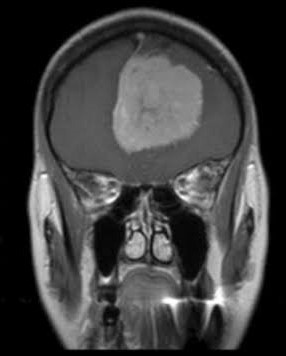

(286, 356)


In [37]:
with Image.open('/Users/aadityajoshi/Downloads/archive-10/meningioma/0010.jpg') as img:
    display(img)
    print(img.size)

In [4]:
root = '/Users/aadityajoshi/Downloads/archive-10'
img_names = []
for folder,sub_folder,filenames in os.walk(root):
    for img in filenames:
        img_names.append(folder + '/' + img)

In [6]:
len(img_names)

7023

In [7]:
img_sizes = []
rejected = []

for item in img_names:
    try : 
        with Image.open(item) as img:
            img_sizes.append(img.size)
    except:
        rejected.append(item)
df = pd.DataFrame(img_sizes)

In [9]:
df.describe()

,0,1
count,7023.000000,7023.000000
mean,445.891499,448.346860
std,132.328035,126.282922
min,150.000000,168.000000
25%,393.000000,403.500000
50%,512.000000,512.000000
75%,512.000000,512.000000
max,1920.000000,1446.000000


### transforms

In [12]:
train_transforms = transforms.Compose([
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(p=0.2),
        transforms.Resize(512),
        transforms.CenterCrop(512),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])])

In [13]:
test_transforms = transforms.Compose([
        transforms.Resize(512),
        transforms.CenterCrop(512),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])])

In [14]:
dataset = datasets.ImageFolder('/Users/aadityajoshi/Downloads/archive-10')

In [15]:
dataset

Dataset ImageFolder
    Number of datapoints: 7023
    Root location: /Users/aadityajoshi/Downloads/archive-10

In [16]:
class_names = dataset.classes

In [17]:
class_names

['glioma', 'healthy', 'meningioma', 'pituitary']

In [44]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

def stratified_split(dataset):
    labels = [item[1] for item in dataset.samples]  
    indices = list(range(len(dataset)))
    train_idx, test_idx = train_test_split(
        indices, train_size=0.8,  
        stratify=labels,
        random_state=42
    )
    train_dataset = Subset(dataset, train_idx)
    test_dataset = Subset(dataset, test_idx)
    return train_dataset, test_dataset,train_idx,test_idx

In [45]:
train_dataset, test_dataset,train_idx,test_idx = stratified_split(dataset)

In [46]:
class TransformDataset:
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, idx):
        x, y = self.subset[idx]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

In [47]:
train_dataset = TransformDataset(
    Subset(dataset, train_idx),
    transform=train_transforms
)

test_dataset = TransformDataset(
    Subset(dataset, test_idx),
    transform=test_transforms
)

In [54]:
train_dataset[0][0]

tensor([[[-2.1179, -2.1179, -2.1179,  ..., -1.9638, -1.9638, -1.9638],
         [-2.1179, -2.1179, -2.1179,  ..., -1.9295, -1.9295, -1.9295],
         [-2.1179, -2.1179, -2.1179,  ..., -1.9124, -1.9124, -1.9124],
         ...,
         [-1.9638, -1.9467, -1.9467,  ..., -2.1179, -2.1179, -2.1179],
         [-1.9467, -1.9295, -1.9295,  ..., -2.1179, -2.1179, -2.1179],
         [-1.9467, -1.9467, -1.9467,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -1.8782, -1.8782, -1.8782],
         [-2.0357, -2.0357, -2.0357,  ..., -1.8431, -1.8431, -1.8431],
         [-2.0357, -2.0357, -2.0357,  ..., -1.8256, -1.8256, -1.8256],
         ...,
         [-1.8782, -1.8606, -1.8606,  ..., -2.0357, -2.0357, -2.0357],
         [-1.8606, -1.8431, -1.8431,  ..., -2.0357, -2.0357, -2.0357],
         [-1.8606, -1.8606, -1.8606,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.6476, -1.6476, -1.6476],
         [-1.8044, -1.8044, -1.8044,  ..., -1

In [55]:
test_dataset[2][0]

tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -1

In [89]:
train_batch_size = 128
test_batch_size = 512
train_loader = DataLoader(train_dataset,train_batch_size,shuffle=True)
test_loader = DataLoader(test_dataset,test_batch_size,shuffle=False)

In [58]:
def dim_calc(n_in,w_in,h_in,f,s,p,num_filters,max_pool,ms,mf):
    #(height,widht)
    if type(s) == tuple: #(2,1)
        s_h = s[0]
        s_w = s[1]
    else:
        s_h,s_w = s,s
    if type(f) == tuple:
        f_h = f[0]
        f_w = f[1]
    else:
        f_h,f_w = f,f
    if type(p) == tuple:
        p_h = p[0]
        p_w = p[1]
    else:
        p_h,p_w = p,p
        
    height = ((h_in-f_h+2*p_h)//s_h)+1
    width = ((w_in-f_w+2*p_w)//s_w)+1
    channels = num_filters
    if max_pool == True:
        height = ((height-mf)//ms)+1
        width = ((width-mf)//ms)+1
    return (channels,height,width)

In [64]:
print(f"1 : {dim_calc(3,512,512,3,1,0,8,True,2,2)}")
print(f"2 : {dim_calc(8, 255, 255,3,1,0,16,True,2,2)}")
print(f"3 : {dim_calc(16, 126, 126,3,1,0,32,True,2,2)}")
print(f"3 : {dim_calc(32, 62, 62,3,1,0,64,True,2,2)}")

1 : (8, 255, 255)
2 : (16, 126, 126)
3 : (32, 62, 62)
3 : (64, 30, 30)


In [63]:
32*62*62

123008

In [65]:
64*30*30

57600

### ConvNet 1

In [90]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=8,stride=1,kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=8,out_channels=16,stride=1,kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=16,out_channels=32,stride=1,kernel_size=3)
        self.conv4 = nn.Conv2d(in_channels=32,out_channels=64,stride=1,kernel_size=3)
        self.fc1 = nn.Linear(64*30*30,512)
        self.fc2 = nn.Linear(512,128)
        self.fc3 = nn.Linear(128,32)
        self.out = nn.Linear(32,4)
        self.dropout = nn.Dropout(p=0.4)
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x,2,2)
        x = x.view(-1,64*30*30)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.out(x)
        return F.log_softmax(x,dim=1)
        

In [91]:
cnn = CNNModel().to(device)

In [76]:
cnn

CNNModel(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=57600, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=4, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)

In [96]:
import time
from tqdm import tqdm
num_epochs = 5
optimizer = torch.optim.Adam(cnn.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

start = time.time()
for epoch in range(num_epochs):
    cnn.train()
    # Wrap your train_loader with tqdm
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    total_loss = 0
    for img, label in pbar:
        img, label = img.to(device), label.to(device)
        y_pred = cnn(img)
        loss = criterion(y_pred, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update total loss and progress bar
        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    # Calculate and print average loss for the epoch
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

print(f"Total training time: {(time.time() - start) / 60:.2f} minutes")

Epoch 1/5: 100%|███████████████████| 44/44 [02:18<00:00,  3.15s/it, loss=0.1006]


Epoch 1/5, Average Loss: 0.0768


Epoch 2/5: 100%|███████████████████| 44/44 [01:49<00:00,  2.48s/it, loss=0.0223]


Epoch 2/5, Average Loss: 0.0620


Epoch 3/5: 100%|███████████████████| 44/44 [01:52<00:00,  2.56s/it, loss=0.0508]


Epoch 3/5, Average Loss: 0.0461


Epoch 4/5: 100%|███████████████████| 44/44 [01:44<00:00,  2.38s/it, loss=0.0543]


Epoch 4/5, Average Loss: 0.0496


Epoch 5/5: 100%|███████████████████| 44/44 [01:39<00:00,  2.26s/it, loss=0.0368]

Epoch 5/5, Average Loss: 0.0511
Total training time: 9.41 minutes


In [93]:
#15 epochs
from sklearn.metrics import classification_report
all_preds = []
all_labels = []

cnn.eval()
with torch.no_grad():
    for img, label in test_loader:
        img, label = img.to(device), label.to(device)
        pred = cnn(img)
        pred = torch.argmax(pred, dim=1)
        
        # Collect predictions and labels
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

# Now, use classification_report with the collected predictions and labels
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       324
           1       0.95      0.99      0.97       400
           2       0.94      0.86      0.90       329
           3       0.97      0.98      0.97       352

    accuracy                           0.95      1405
   macro avg       0.95      0.95      0.95      1405
weighted avg       0.95      0.95      0.95      1405



In [95]:
#20 epochs

from sklearn.metrics import classification_report
all_preds = []
all_labels = []

cnn.eval()
with torch.no_grad():
    for img, label in test_loader:
        img, label = img.to(device), label.to(device)
        pred = cnn(img)
        pred = torch.argmax(pred, dim=1)
        
        # Collect predictions and labels
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

# Now, use classification_report with the collected predictions and labels
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95       324
           1       0.95      0.99      0.97       400
           2       0.94      0.92      0.93       329
           3       0.98      0.98      0.98       352

    accuracy                           0.96      1405
   macro avg       0.96      0.96      0.96      1405
weighted avg       0.96      0.96      0.96      1405



In [ ]:
#25 epochs

from sklearn.metrics import classification_report
all_preds = []
all_labels = []

cnn.eval()
with torch.no_grad():
    for img, label in test_loader:
        img, label = img.to(device), label.to(device)
        pred = cnn(img)
        pred = torch.argmax(pred, dim=1)
        
        # Collect predictions and labels
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

# Now, use classification_report with the collected predictions and labels
print(classification_report(all_labels, all_preds))